In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [2]:
28 79

SyntaxError: invalid syntax (2097164489.py, line 1)

In [ ]:
data_id = "28"
background_filepath = f"./inD-dataset-v1.1/data/{data_id}_background.png"
recordingMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracksMeta.csv"

In [ ]:
tracks_data = pd.read_csv(tracks_filepath)
print(tracks_data['xAcceleration'].max())
filtered_data = tracks_data[tracks_data['trackId'] == 79]
print(filtered_data['xAcceleration'].max())

4.17335
0.77707


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

def plot_sv(track_id=0, data_id="00"):
    # File paths
    background_filepath = f"./inD-dataset-v1.1/data/{data_id}_background.png"
    tracks_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracks.csv"
    tracksMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracksMeta.csv"
    
    image = mpimg.imread(background_filepath)
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    ax.imshow(image)
    
    tracks_data = pd.read_csv(tracks_filepath)
    tracksMeta_data = pd.read_csv(tracksMeta_filepath)
    
    num_frames = tracksMeta_data[tracksMeta_data["trackId"] == track_id]["numFrames"].iloc[0]

    for i in range(num_frames):
        sv_info = tracks_data[(tracks_data["trackId"] == track_id) & (tracks_data["frame"] == i)]
        
        if not sv_info.empty:
            x_center = sv_info["xCenter"].iloc[0]
            y_center = sv_info["yCenter"].iloc[0]
            width = sv_info["width"].iloc[0] 
            length = sv_info["length"].iloc[0]
            
            x_lf = x_center - width / 2
            y_lf = y_center - length / 2
            
            rect = patches.Rectangle((x_lf, y_lf), width, length, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.show()

228.3228080481462


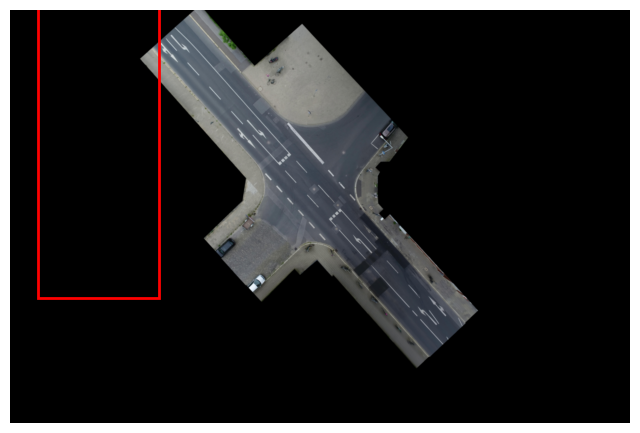

In [ ]:
data = pd.read_csv(tracks_filepath)
image = mpimg.imread(background_filepath)
height, width, _ = image.shape
fig, ax = plt.subplots(figsize=(8, 6)) 
plt.imshow(image)
ratio = 0.00814636091724916
print(1.86/ratio)
rect = patches.Rectangle((51.56722,-41.60204), 1.86488/ratio,4.76778/ratio, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.axis('off')  # Hide axes for better visualization
plt.show()